In [1]:
import sympy
import numpy as np
import scipy.fftpack
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams["font.family"] = "Source Han Sans JP"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 12  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

目標:   
予測に用いる補間多項式の次数の上限(または、拘束点の数) $\bar{n}=4,$サンプリング数$N=8$の時、    
重み係数$W_{k,0}^{L}$ = [0.142, 0.0692, 0.0398, 0.0189, 0.0127, 0.00664, 0.00326] , k=1,2...7を出したい

# 式を整理する

$$W_{k,\hat{k}}^{L} = (1-n)\sqrt{\frac{2}{N}} \lambda_\hat{k} \cos(\pi \hat{k}(\xi_0 + 1))w_{k,0} $$

$\hat{k}=0$の時、$W_{k,0}^{L}$で、この時、$\cos(\pi \hat{k}(\xi_0 + 1))=1$となるので、

$$W_{k,0}^{L} = (1-n)\sqrt{\frac{2}{N}} \lambda_0 w_{k,0} $$

$\bar{n}=4,N=8$を代入して、

$$
\begin{align}
    W_{k,0}^{L} &= (-3) \sqrt{\frac{2}{8}} \lambda_\hat{k} w_{k,0} \\
                &= (-\frac{3}{2}) \lambda_0 w_{k,0}
\end{align}
$$

$\lambda_0 = \frac{1}{\sqrt{2}}$なので、

$$
\begin{align}
    W_{k,0}^{L} &= (-\frac{3}{2})\frac{1}{\sqrt{2}}w_{k,0}\\
                & \simeq -1.06 w_{k,0}
\end{align}
$$

# $w_{k,0}$を求める

次に、$w_{k,0}$を求める

$$w_{k,j}=\sqrt{\frac{2}{N}}\lambda_k \sum_{\ell = 0}^{N-1}L_j(x_\ell)\cos(\pi k x_\ell)$$

$j=0$の時、$w_{k,0}$なので、

$$w_{k,0}=\sqrt{\frac{2}{N}}\lambda_k \sum_{\ell = 0}^{N-1}L_0(x_\ell)\cos(\pi k x_\ell)$$

$L_0(x_\ell)$を求めて、DCTすれば$w_{k,0}$が得られる。

$x_\ell$は、以下の式で与えられるN個のサンプリング点である。

$$
x_\ell = \frac{2\ell+1}{2N} \quad \ell = 0,1,...,N-1
$$

$N=8$なので、$x_\ell$は、

In [2]:
N = 8
x_l = (2 * np.arange(N) + 1) / (2 * N)
x_l

array([0.0625, 0.1875, 0.3125, 0.4375, 0.5625, 0.6875, 0.8125, 0.9375])

## $w_{k,0}$の計算のために$L_0(x_\ell)$ を求める


$$L_j(x) = \int \prod_{\begin{array}{c} \ell = 0\\ \ell \neq qj \end{array}}^{n-1} \frac{(x-s_\ell)}{(s_j - s_\ell)}dx$$

$j=0$の時、$L_0$なので、

$$L_0(x) = \int \prod_{\begin{array}{c} \ell = 0\\ \ell \neq 0 \end{array}}^{n-1} \frac{(x-s_\ell)}{(s_0 - s_\ell)}dx$$


$\bar{n}=4$なので、範囲を整理すると、

$$L_0(x) = \int \prod_{\begin{array}{c} \ell = 1 \end{array}}^{3} \frac{(x-s_\ell)}{(s_0- s_\ell)}dx$$

$s_\ell$は、区間[0,1]に等間隔に配置された$n$個の拘束点であり、以下の式で与えられる。

$$
s_\ell = \frac{\ell}{n-1} \quad \ell=0,1,...,n-1
$$

$\bar{n}=4$なので、

In [18]:
n_bar = 4
s_l = np.arange(n_bar) / (n_bar - 1)
s_l

array([0.        , 0.33333333, 0.66666667, 1.        ])

$s_\ell = 0,\frac{1}{3},\frac{2}{3},1$  
両端点を含む4点が拘束点となる。  

$L_0(x)$を展開してみると、

$$
\begin{align}
    L_0(x)  &= \int \frac{x-s_1}{s_0-s_1} \times \frac{x-s_2}{s_0-s_2} \times \frac{x-s_3}{s_0-s_3} dx\\
            &= \int (-3)(x-\frac{1}{3}) \times (-\frac{3}{2})(x-\frac{2}{3})\times (-1)(x-1)dx\\
            &= \int (1-3x)(1-\frac{3}{2}x)(1-x)dx\\
            &= \int \{(1-\frac{5}{2}x+\frac{3}{2}x^2) + (-3x)(1-\frac{5}{2}x+\frac{3}{2}x^2)\}dx\\
            &= \int (1-\frac{5}{2}x+\frac{3}{2}x^2 -3x+ \frac{15}{2}x^2 -\frac{9}{2}x^3 )dx\\
            &= \int (1-\frac{11}{2}x + 9x^2 - \frac{9}{2}x^3) dx\\
            &= x - \frac{11}{4}x^2 + 3x^3 - \frac{9}{8}x^4
\end{align}
$$

代数計算のライブラリで計算してみると、

In [19]:
x = sympy.Symbol("x")
sympy.integrate((1 - 3 * x) * (1 - (3 / 2) * x) * (1 - x))
# sympy.integrate((x-0.5)/(-0.5) * (x-1)/(-1))
# sympy.integrate((x-1)/(-1))

-1.125*x**4 + 3.0*x**3 - 2.75*x**2 + 1.0*x

同じ式が出てきた

$L_0(x)$に$x=x_\ell$を代入して

In [20]:
L_0 = -1.125 * x_l ** 4 + 3 * x_l ** 3 - 2.75 * x_l ** 2 + 1 * x_l
# L_0 = -0.6667 * x_l ** 3 - 1.5 * x_l **2 + x_l
# L_0 = - x_l ** 2 /2 + x_l
L_0

array([0.05247307, 0.10920525, 0.12476921, 0.12113762, 0.11369133,
       0.11121941, 0.11591911, 0.12339592])

Text(0, 0.5, 'L_0(x_ell)')

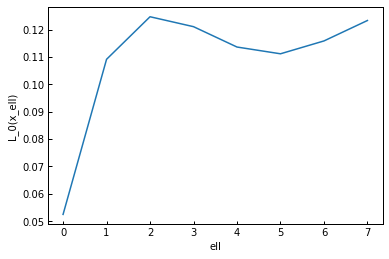

In [21]:
plt.plot(L_0)
plt.xlabel("ell")
plt.ylabel("L_0(x_ell)")

## 求めた$L_0$を使って$w_{k,0}$を求める

$L_0$をDCTしてみると、

In [15]:
w_k0 = []
for k in range(8):
    lambda_k = 1
    if k == 0:
        lambda_k = 1/np.sqrt(2)
        
    tmp = np.sum(L_0 * np.cos(np.pi * k * x_l))
    w_k0.append(np.sqrt(2/N) * lambda_k * tmp)
w_k0

[0.9446504654914033,
 -0.402645188919071,
 -0.09857256343434229,
 -0.0420909250564962,
 -0.022097086912079567,
 -0.012556431483499428,
 -0.007005336393249642,
 -0.0031688951724780506]

DCTのライブラリを使って計算してみると、

In [22]:
w_k0 = scipy.fftpack.dct(L_0,norm="ortho")
w_k0

array([ 0.3082317 , -0.03308095, -0.02931474, -0.03754339, -0.01782441,
       -0.01199148, -0.00626287, -0.00307165])

同じ結果がでた。

# $W^{L}_{k,0}$を求める

$$
\begin{align}
    W_{k,0}^{L} &= (-\frac{3}{2})\frac{1}{\sqrt{2}}w_{k,0}\\
                & \simeq -1.06 w_{k,0}
\end{align}
$$

だったので、$W_{k,0}^L, \quad k=1,2,...,7$は、

In [17]:
-1.06 * w_k0[1:]

array([0.4268039 , 0.10448692, 0.04461638, 0.02342291, 0.01330982,
       0.00742566, 0.00335903])


重み係数$W_{k,0}^{L}$ = [0.142, 0.0692, 0.0398, 0.0189, 0.0127, 0.00664, 0.00326] , k=1,2...7とは違う...。

In [31]:
w_l_k0 = []
for k in range(8):
    lambda_k = 1
    if k == 0:
        lambda_k = 1/np.sqrt(2)
        
    tmp = np.sum(np.cos(np.pi * k * (xi[0] + 1)) * w_k0)
    w_l_k0.append((1-4) * np.sqrt(2/N) * lambda_k * tmp)

In [25]:
xi = (np.arange(n_bar+1)-0.5)/(n_bar-1)
xi

array([-0.16666667,  0.16666667,  0.5       ,  0.83333333,  1.16666667])

In [32]:
w_l_k0

[-0.1794024238833261,
 0.21972219856632358,
 -0.12685667048920335,
 -7.767730773254666e-17,
 0.12685667048920327,
 -0.2197221985663235,
 0.25371334097840664,
 -0.21972219856632358]